## I Load the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

data = pd.concat([df1, df2])

## II Embedding

In [ ]:
!pip install sent2vec

In [4]:
import gensim
from tqdm import tqdm

In [5]:
import nltk
from nltk import word_tokenize

In [6]:
from sent2vec.vectorizer import Vectorizer

In [ ]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales,InvoiceDay
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01


### a. Sentence to vec

In [7]:
a = list(data['Description'].dropna().drop_duplicates().map(lambda x: str(x)))

In [8]:
vectorizer = Vectorizer()
vectorizer.run(a)
vectors = vectorizer.vectors

Initializing Bert distilbert-base-uncased
Vectorization done on cuda


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
vectors_std = StandardScaler().fit_transform(vectors)

### b. Use the AVG of word embedding as sentence embedding

In [ ]:
# description = []
# for i in data['Description'].dropna().drop_duplicates():
#     description.append(word_tokenize(str(i)))

In [ ]:
# w2v_model = gensim.models.Word2Vec(description)
# embed = []
# for i in description:
#     sent = np.zeros(100)
#     for j in i:
#         sent += w2v_model.wv.get_vector(j)
#     sent = sent/len(i)
#     embed.append(sent)

## III Clustering

In [11]:
from sklearn.cluster import KMeans

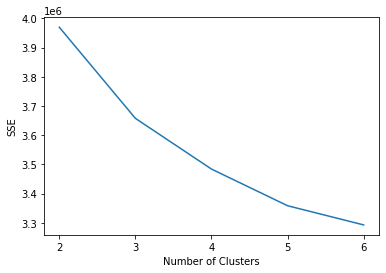

In [13]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}
sse = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectors_std)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(2, 7), sse)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [14]:
kmeans = KMeans(5,**kmeans_kwargs)
kmeans.fit(vectors_std);

In [25]:
dic = {}
k = 0
for i in data['Description'].dropna().drop_duplicates():
    dic[str(i)]=kmeans.labels_[k]
    k+=1

In [ ]:
# sorted(dic.items(),key = lambda x:x[1])

In [26]:
data['cluster'] = [dic[str(i)] if i!=-1 else -1 for i in data['Description'].fillna(-1)]

In [18]:
data_0 = data[data['cluster']==0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cluster
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,0
18,489436,22296,HEART IVORY TRELLIS LARGE,12,2009-12-01 09:06:00,1.65,13078.0,United Kingdom,0
19,489436,22295,HEART FILIGREE DOVE LARGE,12,2009-12-01 09:06:00,1.65,13078.0,United Kingdom,0
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,0
541898,581587,22727,ALARM CLOCK BAKELIKE RED,4,2011-12-09 12:50:00,3.75,12680.0,France,0
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09 12:50:00,3.75,12680.0,France,0
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France,0


In [19]:
data_1 = data[data['cluster']==1]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cluster
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,1
46,489437,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,2009-12-01 09:08:00,0.85,15362.0,United Kingdom,1
57,489438,21033,JUMBO BAG CHARLIE AND LOLA TOYS,30,2009-12-01 09:24:00,2.00,18102.0,United Kingdom,1
68,489438,85132C,CHARLIE AND LOLA FIGURES TINS,60,2009-12-01 09:24:00,6.40,18102.0,United Kingdom,1
91,489440,22349,"DOG BOWL , CHASING BALL DESIGN",8,2009-12-01 09:43:00,3.75,18087.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
541868,581584,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,48,2011-12-09 12:25:00,1.85,13777.0,United Kingdom,1
541871,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,1
541876,581585,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,24,2011-12-09 12:31:00,0.85,15804.0,United Kingdom,1
541884,581585,84946,ANTIQUE SILVER T-LIGHT GLASS,12,2011-12-09 12:31:00,1.25,15804.0,United Kingdom,1


In [20]:
data_2 = data[data['cluster']==2]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cluster
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,2
10,489435,22195,HEART MEASURING SPOONS LARGE,24,2009-12-01 07:46:00,1.65,13085.0,United Kingdom,2
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom,2
13,489436,21755,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.45,13078.0,United Kingdom,2
...,...,...,...,...,...,...,...,...,...
541874,581585,23084,RABBIT NIGHT LIGHT,12,2011-12-09 12:31:00,2.08,15804.0,United Kingdom,2
541885,581585,21684,SMALL MEDINA STAMPED METAL BOWL,12,2011-12-09 12:31:00,0.85,15804.0,United Kingdom,2
541893,581586,20685,DOORMAT RED RETROSPOT,10,2011-12-09 12:49:00,7.08,13113.0,United Kingdom,2
541895,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-12-09 12:50:00,1.65,12680.0,France,2


In [21]:
data_3 = data[data['cluster']==3]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,3
15,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.69,13078.0,United Kingdom,3
44,489437,21987,PACK OF 6 SKULL PAPER CUPS,12,2009-12-01 09:08:00,0.65,15362.0,United Kingdom,3
45,489437,21989,PACK OF 20 SKULL PAPER NAPKINS,12,2009-12-01 09:08:00,0.85,15362.0,United Kingdom,3
74,489439,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12,2009-12-01 09:28:00,2.55,12682.0,France,3
...,...,...,...,...,...,...,...,...,...
541887,581585,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,2011-12-09 12:31:00,3.75,15804.0,United Kingdom,3
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,3
541896,581587,22555,PLASTERS IN TIN STRONGMAN,12,2011-12-09 12:50:00,1.65,12680.0,France,3
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,3


In [22]:
data_4 = data[data['cluster']==4]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,cluster
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,4
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,4
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,4
11,489435,22353,LUNCHBOX WITH CUTLERY FAIRY CAKES,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,4
...,...,...,...,...,...,...,...,...,...
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0,France,4
541902,581587,22629,SPACEBOY LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France,4
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France,4
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,4


In [31]:
from sklearn import manifold

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


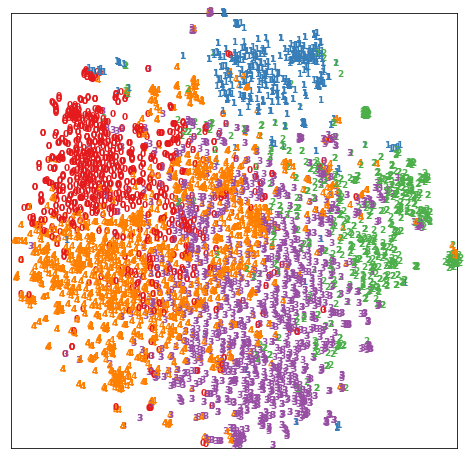

In [33]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(vectors_std)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # normalization
plt.figure(figsize=(8, 8))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(kmeans.labels_[i]), color=plt.cm.Set1(kmeans.labels_[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()